In [31]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [32]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [33]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [34]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [35]:
forecasting = 20

In [36]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [37]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

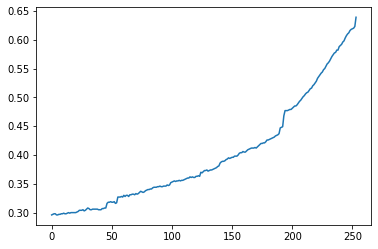

In [38]:
df = df[:254]
df.plot()

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [40]:
train = df_scaled

In [67]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size-19):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size:i+window_size+20]))
    return np.array(feature_list), np.array(label_list)

In [68]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [69]:
train_feature.shape
print(train_feature)

[[[0.        ]
  [0.00291545]
  [0.0058309 ]
  ...
  [0.01166181]
  [0.01166181]
  [0.01166181]]

 [[0.00291545]
  [0.0058309 ]
  [0.0058309 ]
  ...
  [0.01166181]
  [0.01166181]
  [0.01166181]]

 [[0.0058309 ]
  [0.0058309 ]
  [0.        ]
  ...
  [0.01166181]
  [0.01166181]
  [0.01457726]]

 ...

 [[0.6180758 ]
  [0.62099125]
  [0.62973761]
  ...
  [0.7638484 ]
  [0.7696793 ]
  [0.77842566]]

 [[0.62099125]
  [0.62973761]
  [0.63848397]
  ...
  [0.7696793 ]
  [0.77842566]
  [0.79008746]]

 [[0.62973761]
  [0.63848397]
  [0.64139942]
  ...
  [0.77842566]
  [0.79008746]
  [0.80174927]]]


In [70]:
train_label.shape

(215, 20, 1)

In [71]:
x_train.shape

(172, 20, 1)

In [72]:
y_train.shape

(172, 20, 1)

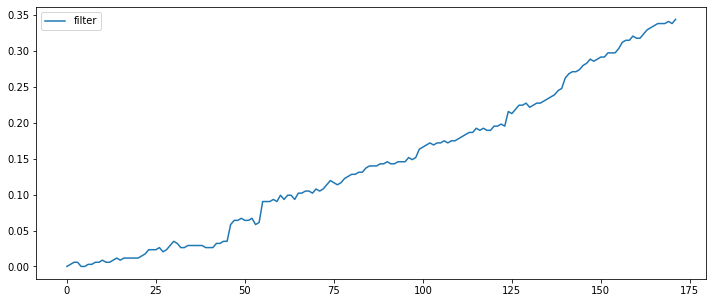

In [73]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

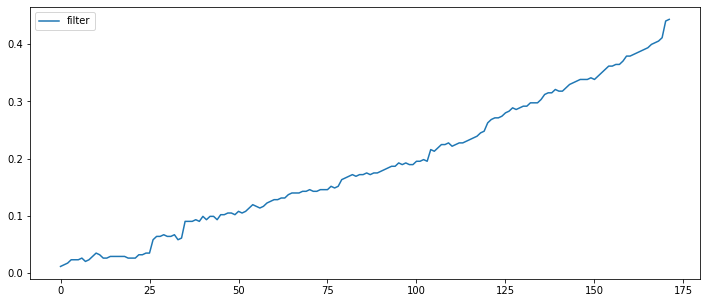

In [74]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [75]:
OUT_STEPS = 20

In [76]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [ ]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')



h = model.fit(x_train, y_train, 
                    epochs=1000, 
                    batch_size=1)

#model.save('model20.h5')

Train on 172 samples
Epoch 1/1000
172/172 [==============================] - 6s 36ms/sample - loss: 0.0219 - mean_absolute_error: 0.0949
Epoch 2/1000
172/172 [==============================] - 4s 23ms/sample - loss: 6.7624e-04 - mean_absolute_error: 0.0193
Epoch 3/1000
172/172 [==============================] - 4s 23ms/sample - loss: 6.9156e-04 - mean_absolute_error: 0.0191
Epoch 4/1000
172/172 [==============================] - 4s 23ms/sample - loss: 4.9785e-04 - mean_absolute_error: 0.0159
Epoch 5/1000
172/172 [==============================] - 4s 23ms/sample - loss: 4.3631e-04 - mean_absolute_error: 0.0156
Epoch 6/1000
172/172 [==============================] - 4s 23ms/sample - loss: 3.9613e-04 - mean_absolute_error: 0.0146
Epoch 7/1000
172/172 [==============================] - 4s 23ms/sample - loss: 6.0128e-04 - mean_absolute_error: 0.0178
Epoch 8/1000
172/172 [==============================] - 4s 23ms/sample - loss: 5.6449e-04 - mean_absolute_error: 0.0183
Epoch 9/1000
172/172 [=

172/172 [==============================] - 4s 23ms/sample - loss: 3.4109e-04 - mean_absolute_error: 0.0126
Epoch 69/1000
172/172 [==============================] - 4s 24ms/sample - loss: 2.7674e-04 - mean_absolute_error: 0.0115
Epoch 70/1000
172/172 [==============================] - 4s 24ms/sample - loss: 4.1273e-04 - mean_absolute_error: 0.0141
Epoch 71/1000
172/172 [==============================] - 4s 23ms/sample - loss: 3.6092e-04 - mean_absolute_error: 0.0135
Epoch 72/1000
172/172 [==============================] - 4s 25ms/sample - loss: 2.2561e-04 - mean_absolute_error: 0.0106
Epoch 73/1000
172/172 [==============================] - 4s 24ms/sample - loss: 2.7318e-04 - mean_absolute_error: 0.0111
Epoch 74/1000
172/172 [==============================] - 4s 24ms/sample - loss: 2.3244e-04 - mean_absolute_error: 0.0105
Epoch 75/1000
172/172 [==============================] - 4s 24ms/sample - loss: 2.8103e-04 - mean_absolute_error: 0.0114
Epoch 76/1000
172/172 [=======================

172/172 [==============================] - 4s 26ms/sample - loss: 1.3788e-04 - mean_absolute_error: 0.0079
Epoch 136/1000
172/172 [==============================] - 4s 25ms/sample - loss: 1.4731e-04 - mean_absolute_error: 0.0082
Epoch 137/1000
172/172 [==============================] - 4s 26ms/sample - loss: 1.4308e-04 - mean_absolute_error: 0.0081
Epoch 138/1000
172/172 [==============================] - 4s 26ms/sample - loss: 1.7393e-04 - mean_absolute_error: 0.0084
Epoch 139/1000
172/172 [==============================] - 4s 26ms/sample - loss: 1.5559e-04 - mean_absolute_error: 0.0084
Epoch 140/1000
172/172 [==============================] - 4s 26ms/sample - loss: 1.5232e-04 - mean_absolute_error: 0.0085
Epoch 141/1000
172/172 [==============================] - 4s 25ms/sample - loss: 1.6454e-04 - mean_absolute_error: 0.0085
Epoch 142/1000
172/172 [==============================] - 4s 25ms/sample - loss: 1.3946e-04 - mean_absolute_error: 0.0081
Epoch 143/1000
172/172 [===============

172/172 [==============================] - 5s 29ms/sample - loss: 1.1921e-04 - mean_absolute_error: 0.0076
Epoch 203/1000
172/172 [==============================] - 5s 29ms/sample - loss: 2.0030e-04 - mean_absolute_error: 0.0095
Epoch 204/1000
172/172 [==============================] - 5s 28ms/sample - loss: 1.3253e-04 - mean_absolute_error: 0.0081
Epoch 205/1000
172/172 [==============================] - 5s 29ms/sample - loss: 1.4488e-04 - mean_absolute_error: 0.0082
Epoch 206/1000
172/172 [==============================] - 5s 29ms/sample - loss: 1.1895e-04 - mean_absolute_error: 0.0075
Epoch 207/1000
172/172 [==============================] - 5s 28ms/sample - loss: 1.3678e-04 - mean_absolute_error: 0.0078
Epoch 208/1000
172/172 [==============================] - 5s 28ms/sample - loss: 1.2133e-04 - mean_absolute_error: 0.0076
Epoch 209/1000
172/172 [==============================] - 5s 29ms/sample - loss: 1.3050e-04 - mean_absolute_error: 0.0077
Epoch 210/1000
172/172 [===============

172/172 [==============================] - 5s 29ms/sample - loss: 8.9309e-05 - mean_absolute_error: 0.0066
Epoch 270/1000
172/172 [==============================] - 5s 30ms/sample - loss: 9.1484e-05 - mean_absolute_error: 0.0069
Epoch 271/1000
172/172 [==============================] - 5s 30ms/sample - loss: 8.7717e-05 - mean_absolute_error: 0.0065
Epoch 272/1000
172/172 [==============================] - 5s 29ms/sample - loss: 9.2453e-05 - mean_absolute_error: 0.0068
Epoch 273/1000
172/172 [==============================] - 5s 29ms/sample - loss: 1.3826e-04 - mean_absolute_error: 0.0077
Epoch 274/1000
172/172 [==============================] - 5s 30ms/sample - loss: 9.0775e-05 - mean_absolute_error: 0.0068
Epoch 275/1000
172/172 [==============================] - 5s 30ms/sample - loss: 7.9646e-05 - mean_absolute_error: 0.0063
Epoch 276/1000
172/172 [==============================] - 5s 29ms/sample - loss: 7.7399e-05 - mean_absolute_error: 0.0063
Epoch 277/1000
172/172 [===============

172/172 [==============================] - 6s 34ms/sample - loss: 7.2064e-05 - mean_absolute_error: 0.0060
Epoch 337/1000
172/172 [==============================] - 6s 33ms/sample - loss: 7.5021e-05 - mean_absolute_error: 0.0064
Epoch 338/1000
172/172 [==============================] - 6s 33ms/sample - loss: 7.1305e-05 - mean_absolute_error: 0.0061
Epoch 339/1000
172/172 [==============================] - 6s 32ms/sample - loss: 6.3965e-05 - mean_absolute_error: 0.0059
Epoch 340/1000
172/172 [==============================] - 6s 33ms/sample - loss: 9.1229e-05 - mean_absolute_error: 0.0068
Epoch 341/1000
172/172 [==============================] - 6s 34ms/sample - loss: 1.1202e-04 - mean_absolute_error: 0.0073
Epoch 342/1000
172/172 [==============================] - 6s 35ms/sample - loss: 1.0193e-04 - mean_absolute_error: 0.0072
Epoch 343/1000
172/172 [==============================] - 6s 36ms/sample - loss: 7.8125e-05 - mean_absolute_error: 0.0063
Epoch 344/1000
172/172 [===============

172/172 [==============================] - 12s 67ms/sample - loss: 1.1775e-04 - mean_absolute_error: 0.0074
Epoch 404/1000
172/172 [==============================] - 11s 61ms/sample - loss: 8.5756e-05 - mean_absolute_error: 0.0066
Epoch 405/1000
172/172 [==============================] - 11s 65ms/sample - loss: 8.3030e-05 - mean_absolute_error: 0.0066
Epoch 406/1000
172/172 [==============================] - 11s 66ms/sample - loss: 8.7782e-05 - mean_absolute_error: 0.0065
Epoch 407/1000
172/172 [==============================] - 11s 67ms/sample - loss: 7.8927e-05 - mean_absolute_error: 0.0064
Epoch 408/1000
172/172 [==============================] - 11s 67ms/sample - loss: 8.1148e-05 - mean_absolute_error: 0.0065
Epoch 409/1000
172/172 [==============================] - 12s 70ms/sample - loss: 8.8586e-05 - mean_absolute_error: 0.0065
Epoch 410/1000
172/172 [==============================] - 12s 70ms/sample - loss: 8.8437e-05 - mean_absolute_error: 0.0068
Epoch 411/1000
172/172 [=======

172/172 [==============================] - 5s 26ms/sample - loss: 6.3598e-05 - mean_absolute_error: 0.0058
Epoch 470/1000
172/172 [==============================] - 4s 24ms/sample - loss: 6.8922e-05 - mean_absolute_error: 0.0060
Epoch 471/1000
172/172 [==============================] - 4s 25ms/sample - loss: 8.4145e-05 - mean_absolute_error: 0.0065
Epoch 472/1000
172/172 [==============================] - 4s 24ms/sample - loss: 7.8853e-05 - mean_absolute_error: 0.0065
Epoch 473/1000
143/172 [=======================>......] - ETA: 0s - loss: 7.4483e-05 - mean_absolute_error: 0.0063

num 0 14.02081893040578 actual 0.6190476190476186 prediction 0.5322521
num 1 44.08939182758338 actual 0.5714285714285712 prediction 0.82336795
num 2 0.011280866769575617 actual 0.6190476190476186 prediction 0.6189778
num 3 30.34214377403271 actual 0.6666666666666661 prediction 0.8689476
num 4 28.17982316017143 actual 0.7142857142857135 prediction 0.51300126
num 5 2.1291472017763913 actual 0.7619047619047628 prediction 0.77812684
num 6 23.464683294296396 actual 0.7142857142857135 prediction 0.8818906
num 7 38.87299895286572 actual 0.6666666666666661 prediction 0.92582
num 8 71.75496816635147 actual 0.6666666666666661 prediction 1.1450331
num 9 85.2819204330446 actual 0.6666666666666661 prediction 1.2352128
num 10 119.89989280700708 actual 0.7142857142857135 prediction 1.5707135
num 11 127.645380496979 actual 0.7142857142857135 prediction 1.6260384
num 12 132.63973712921165 actual 0.7142857142857135 prediction 1.6617124
num 13 98.46712350845354 actual 0.6666666666666661 prediction 1.3231

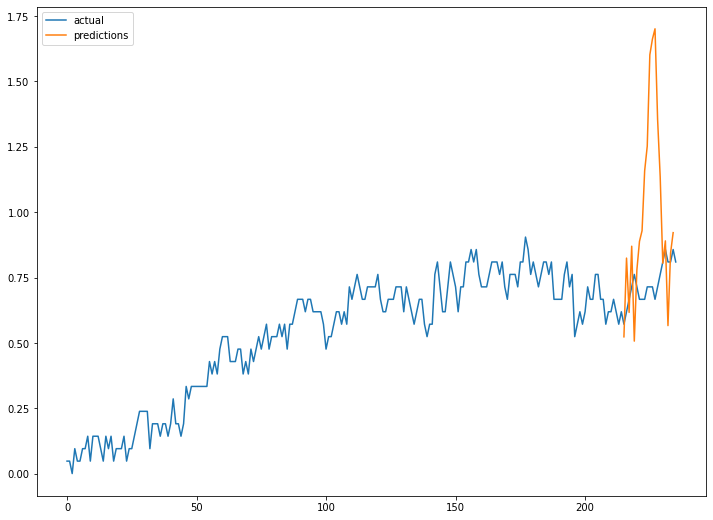

In [52]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 33.53840420480633 actual 0.7973856209150325 prediction 0.5299552
num 1 9.09059135640256 actual 0.7973856209150325 prediction 0.8698727
num 2 18.52052236089899 actual 0.8006535947712417 prediction 0.65236837
num 3 14.078746063093984 actual 0.8104575163398693 prediction 0.9245598
num 4 38.13009003558791 actual 0.8137254901960784 prediction 0.5034512
num 5 0.9833226680755597 actual 0.8169934640522876 prediction 0.8089598
num 6 16.027183818817143 actual 0.8169934640522876 prediction 0.9479345
num 7 18.2944408925881 actual 0.8202614379084967 prediction 0.9703237
num 8 51.17347202753362 actual 0.826797385620915 prediction 1.2498983
num 9 57.83185530453922 actual 0.8366013071895424 prediction 1.3204234
num 10 102.84243743852302 actual 0.8464052287581698 prediction 1.716869
num 11 107.87198461335284 actual 0.8529411764705881 prediction 1.7730258
num 12 109.25616655966179 actual 0.8594771241830064 prediction 1.7985089
num 13 63.7303401123394 actual 0.8627450980392155 prediction 1.4125755


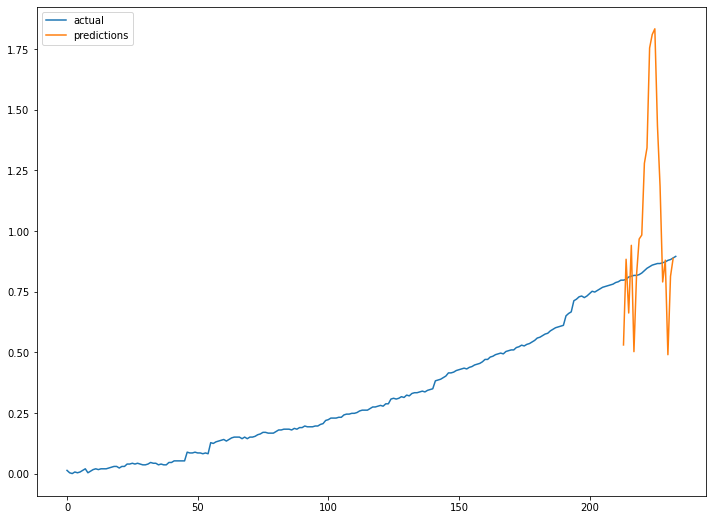

In [53]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 201.86686515808097 actual 0.5874673629242821 prediction 1.7733693
num 1 187.05580488840732 actual 0.5874673629242821 prediction 1.6863592
num 2 208.13847441143452 actual 0.5874673629242821 prediction 1.810213
num 3 404.6862585429051 actual 0.5926892950391647 prediction 2.9912214
num 4 356.08540064437784 actual 0.5926892950391647 prediction 2.7031693
num 5 428.2242004285779 actual 0.5953002610966058 prediction 3.14452
num 6 387.73687944330004 actual 0.6057441253263709 prediction 2.9544375
num 7 442.75528973546506 actual 0.6057441253263709 prediction 3.2877083
num 8 432.40259236020586 actual 0.608355091383812 prediction 3.2388983
num 9 465.143836150735 actual 0.616187989556136 prediction 3.4823484
num 10 425.81549321903884 actual 0.6214099216710185 prediction 3.2674696
num 11 483.58471502406945 actual 0.6292428198433422 prediction 3.672165
num 12 406.89025785102217 actual 0.6370757180156659 prediction 3.2292747
num 13 433.59951023163825 actual 0.6422976501305484 prediction 3.427297

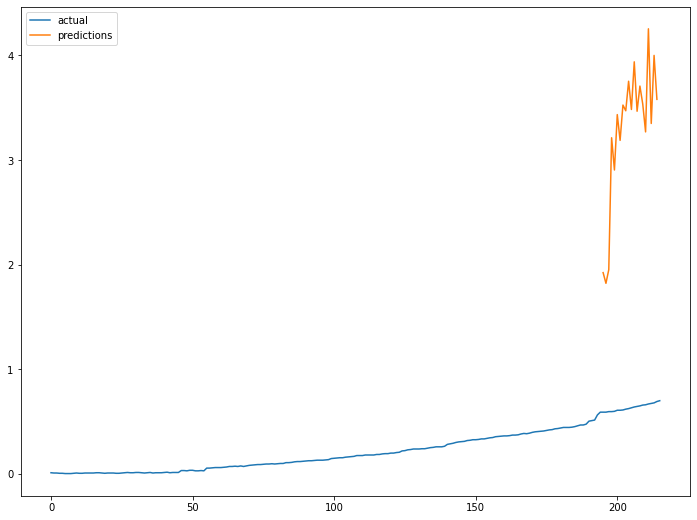

In [81]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.71992864106824 actual 0.7916666666666661 prediction 0.7226339
num 1 7.147231854890452 actual 0.7916666666666661 prediction 0.7350844
num 2 2.4192860251978097 actual 0.7916666666666661 prediction 0.772514
num 3 2.016758918762207 actual 0.75 prediction 0.7651257
num 4 3.126003867701408 actual 0.7916666666666661 prediction 0.76691914
num 5 10.669898986816406 actual 0.75 prediction 0.83002424
num 6 0.7803392410279025 actual 0.8333333333333339 prediction 0.8268305
num 7 8.514809608459394 actual 0.8333333333333339 prediction 0.9042901
num 8 0.41156682101169484 actual 0.9166666666666661 prediction 0.92043936
num 9 4.0029401364534385 actual 0.9583333333333339 prediction 0.9199718
num 10 1.9266418788743425 actual 0.9583333333333339 prediction 0.976797
num 11 0.48144381979243583 actual 0.9583333333333339 prediction 0.9537195
num 12 4.0717995685079185 actual 0.9583333333333339 prediction 0.99735475
num 13 1.0123066280199746 actual 0.9583333333333339 prediction 0.94863206
num 14 8.74761234

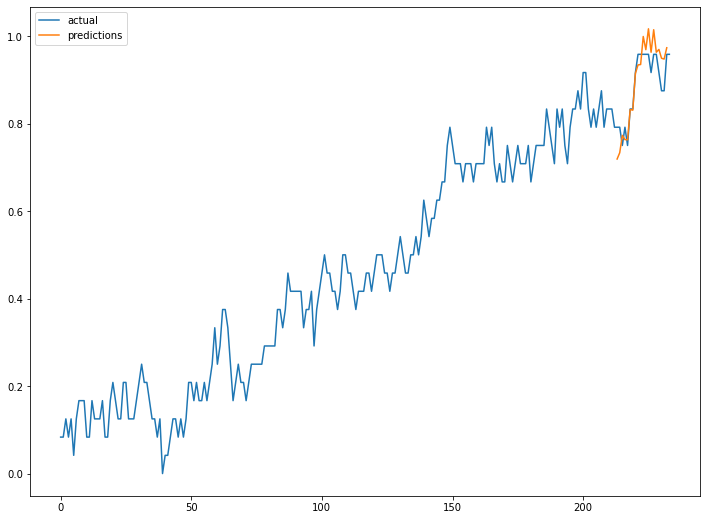

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.926965010793573 actual 0.8482142857142856 prediction 0.7385659
num 1 11.52720848719275 actual 0.8571428571428568 prediction 0.7583382
num 2 6.55688737568101 actual 0.8482142857142856 prediction 0.79259783
num 3 8.807928275063373 actual 0.8526785714285712 prediction 0.77757525
num 4 10.815949784111712 actual 0.8660714285714284 prediction 0.7723976
num 5 2.331270490373884 actual 0.875 prediction 0.8546014
num 6 3.7702860565959964 actual 0.8794642857142856 prediction 0.84630597
num 7 5.8324468794780016 actual 0.8883928571428568 prediction 0.9402079
num 8 8.315273246379846 actual 0.8839285714285712 prediction 0.95742965
num 9 6.920582565230986 actual 0.8883928571428568 prediction 0.9498748
num 10 16.10424735329371 actual 0.8839285714285712 prediction 1.0262786
num 11 9.556466102600107 actual 0.8928571428571428 prediction 0.97818273
num 12 13.728825408633433 actual 0.901785714285714 prediction 1.0255903
num 13 5.31988472774111 actual 0.90625 prediction 0.95446146
num 14 11.80648803

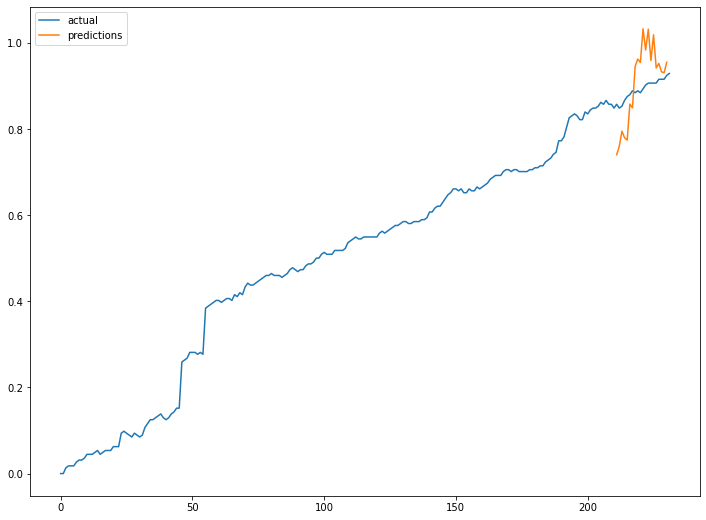

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.874088567846107 actual 0.8500000000000014 prediction 0.74057025
num 1 4.729276895523156 actual 0.8000000000000007 prediction 0.7621658
num 2 5.387028058369955 actual 0.75 prediction 0.7904027
num 3 2.8403600056966143 actual 0.75 prediction 0.7713027
num 4 2.041959762573242 actual 0.75 prediction 0.7653147
num 5 13.193416595458984 actual 0.75 prediction 0.8489506
num 6 19.73328249795078 actual 0.7000000000000011 prediction 0.838133
num 7 32.7423197882514 actual 0.7000000000000011 prediction 0.92919624
num 8 45.15662193298332 actual 0.6500000000000004 prediction 0.94351804
num 9 33.651077747344765 actual 0.7000000000000011 prediction 0.93555754
num 10 34.38976605733235 actual 0.75 prediction 1.0079232
num 11 27.61859893798828 actual 0.75 prediction 0.9571395
num 12 42.92211191994782 actual 0.7000000000000011 prediction 1.0004548
num 13 32.49262741633804 actual 0.7000000000000011 prediction 0.9274484
num 14 23.223416507244004 actual 0.8000000000000007 prediction 0.98578733
num 15

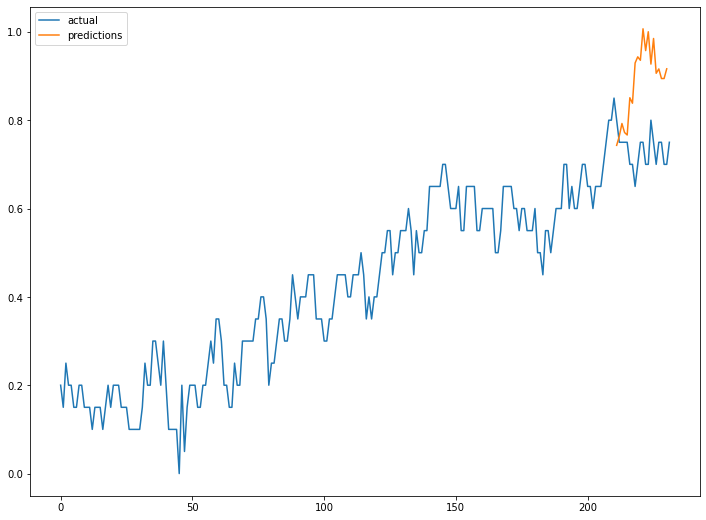

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 13.189190998673341 actual 0.8421052631578938 prediction 0.7310384
num 1 13.724162361838582 actual 0.8684210526315788 prediction 0.74923754
num 2 7.568241283297436 actual 0.8421052631578938 prediction 0.7783727
num 3 11.607775182434988 actual 0.8684210526315788 prediction 0.7676167
num 4 11.869091698617627 actual 0.8684210526315788 prediction 0.76534736
num 5 0.8889812976120802 actual 0.8421052631578938 prediction 0.8346191
num 6 1.646585233749981 actual 0.8157894736842097 prediction 0.82922214
num 7 11.639456979690168 actual 0.8157894736842097 prediction 0.91074294
num 8 9.800964593887452 actual 0.8421052631578938 prediction 0.9246397
num 9 8.857616037130477 actual 0.8421052631578938 prediction 0.9166957
num 10 13.042389624046583 actual 0.8684210526315788 prediction 0.9816839
num 11 11.74959465861333 actual 0.8421052631578938 prediction 0.9410492
num 12 9.783824051127754 actual 0.8947368421052628 prediction 0.9822763
num 13 6.229505033204073 actual 0.8684210526315788 prediction 0

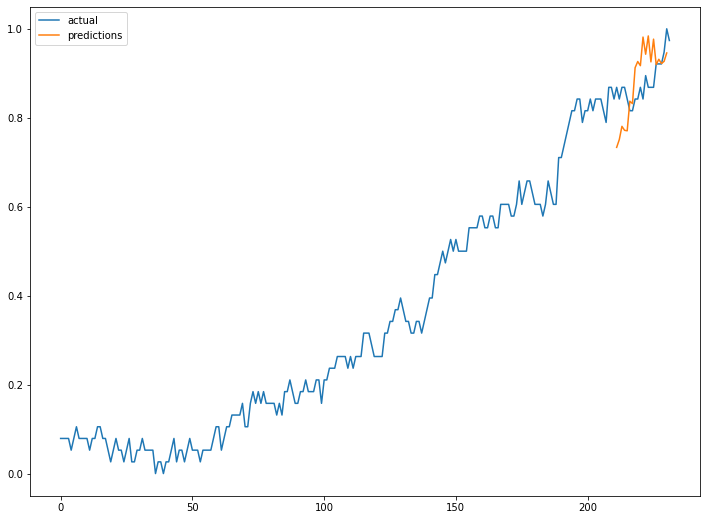

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.54519724845896 actual 0.76923076923077 prediction 0.7034985
num 1 1.830311825401033 actual 0.7307692307692317 prediction 0.7173939
num 2 1.8020623608638031 actual 0.7307692307692317 prediction 0.74393815
num 3 1.2421564051978142 actual 0.7307692307692317 prediction 0.7398465
num 4 6.934426228205469 actual 0.6923076923076916 prediction 0.74031526
num 5 3.1721407175062986 actual 0.76923076923077 prediction 0.79363185
num 6 1.4062336512975164 actual 0.8076923076923084 prediction 0.79633427
num 7 6.711484137035462 actual 0.8076923076923084 prediction 0.86190045
num 8 3.3093804662877195 actual 0.8461538461538467 prediction 0.8741563
num 9 7.8764166150773365 actual 0.8076923076923084 prediction 0.8713095
num 10 19.869971275329462 actual 0.76923076923077 prediction 0.9220767
num 11 16.186029314994688 actual 0.76923076923077 prediction 0.8937387
num 12 20.802701711654535 actual 0.76923076923077 prediction 0.92925155
num 13 9.99737183252961 actual 0.8076923076923084 prediction 0.8884403

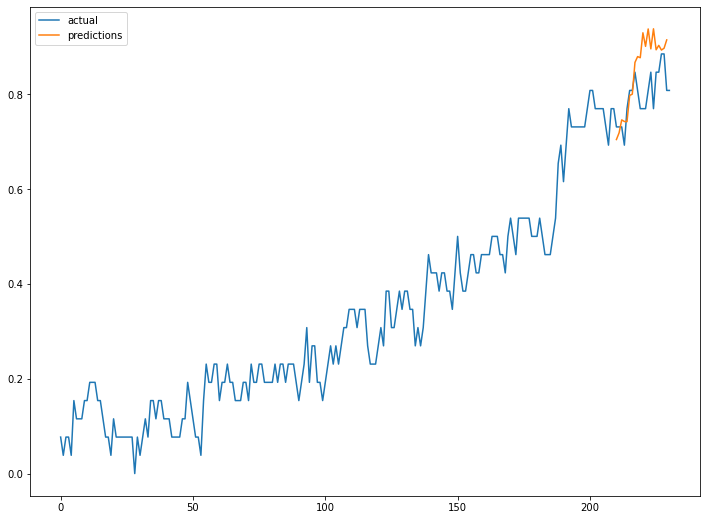

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.109954595565766 actual 0.7389162561576352 prediction 0.6789905
num 1 7.885692229396415 actual 0.7487684729064039 prediction 0.6897229
num 2 5.38432064399216 actual 0.7536945812807878 prediction 0.71311325
num 3 6.120860576629607 actual 0.7586206896551722 prediction 0.7121866
num 4 7.152747038083193 actual 0.7684729064039408 prediction 0.713506
num 5 2.007581056303286 actual 0.7733990147783252 prediction 0.7578724
num 6 1.7071719411052875 actual 0.7783251231527091 prediction 0.7650378
num 7 4.569904759245123 actual 0.7832512315270934 prediction 0.81904507
num 8 5.222646221518526 actual 0.7881773399014778 prediction 0.82934105
num 9 4.78907175686048 actual 0.7931034482758621 prediction 0.83108574
num 10 9.164985756815259 actual 0.798029556650246 prediction 0.87116885
num 11 6.66820381158668 actual 0.798029556650246 prediction 0.8512438
num 12 9.123988086130574 actual 0.8078817733990147 prediction 0.8815928
num 13 3.676494795405251 actual 0.8226600985221673 prediction 0.85290515
n

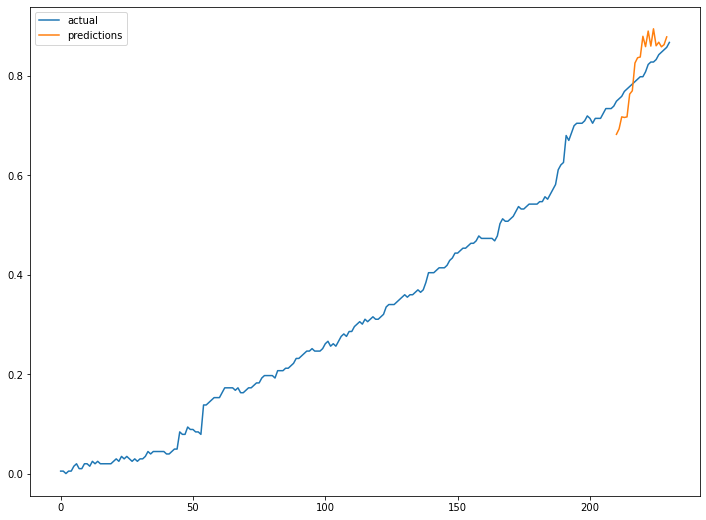

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()